In [1]:
import scipy
import torch
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../")
from tqdm import tqdm
from models import RNNGC
from dataset import DatasetMaker

from review_utils import LinearDecoder, decode, band_score
plt.style.use("../project_style.mplstyle")

In [2]:
## Training parameters
train_steps = 50000
timesteps = 10
bs = 64 # batch size

# Model parameters
ng = 256 # no. of recurrent units

In [3]:
# instantiate RNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RNNGC()
# model = model.load("./saved-models/RNNGC.pkl")

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [4]:
dataset = DatasetMaker()

(-6.283185307179586, 6.283185307179586, -6.283185307179586, 6.283185307179586)

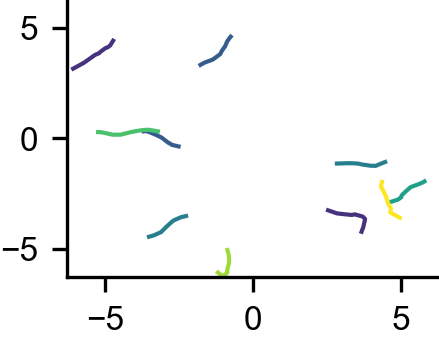

In [5]:
rt, vt = dataset.generate_data(10, timesteps, "cpu")

for i in range(10):
  plt.plot(rt[i,...,0], rt[i,...,1])
plt.axis(2*np.pi*np.array([-1, 1, -1, 1]))

In [6]:
check_steps = [0, 100, 1000, 10000, 49999]

In [7]:
# loss_history = []
# for i in tqdm(range(train_steps)):
#     if i in check_steps:
#         model.save(f"./train_history_models/RNNGC_{i}.pkl")

#     r, v = dataset.generate_data(bs, timesteps, device)
#     loss = model.train_step(inputs = (r[:,0], v), labels = r, optimizer = optimizer)
#     loss_history.append(loss.item())

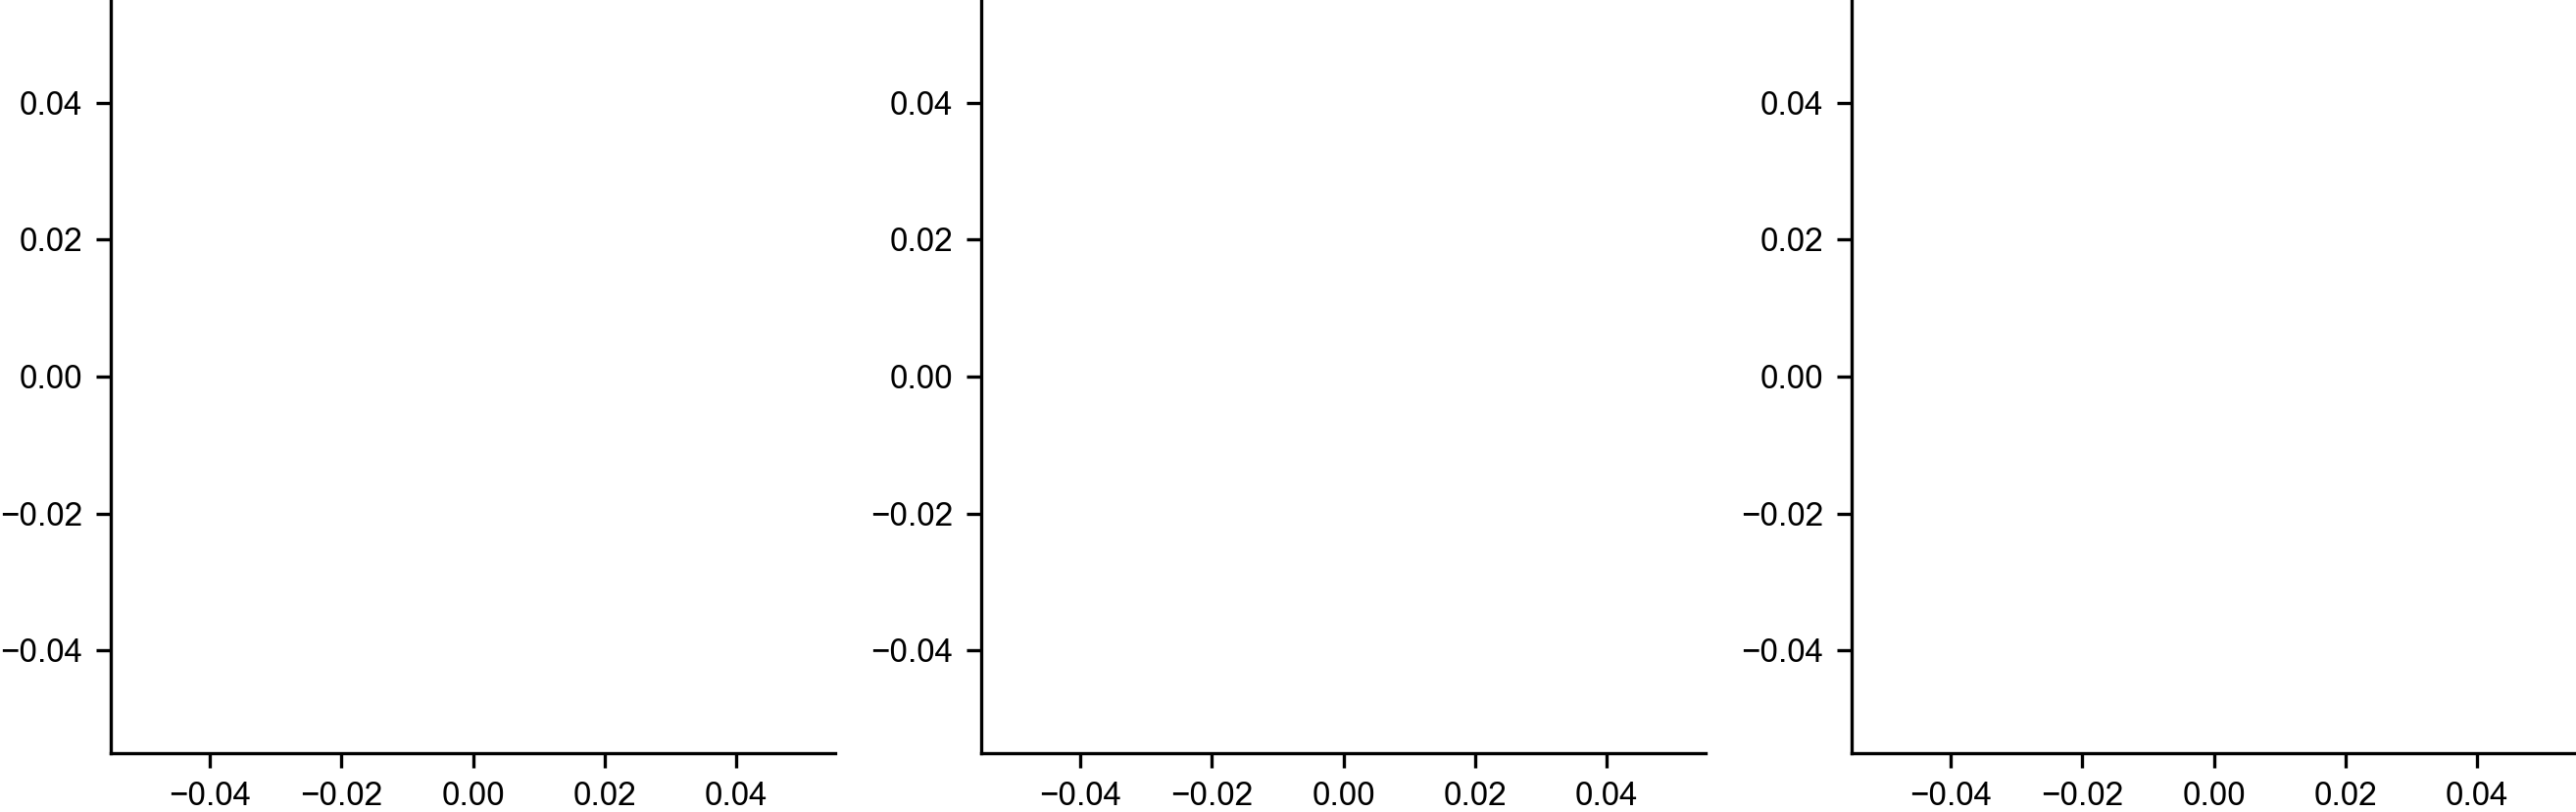

In [8]:
fig,axs = plt.subplots(1,3,figsize=(9,3))
axs[0].plot(np.array(model.total_loss_history))
axs[1].plot(np.array(model.capacity_loss_history))
axs[2].plot(model.distance_loss_history)
fig.tight_layout()

In [9]:
name = f"./train_history_models/RNNGC_{1000}.pkl"
model = RNNGC()
model = model.load(name)

r, v = dataset.generate_data(10000, timesteps, device)
g = model((r[:,0], v))

r = r.detach().cpu().numpy()
g = g.detach().cpu().numpy()

In [10]:
ratemaps = scipy.stats.binned_statistic_2d(r[...,0].ravel(), r[...,1].ravel(), g.reshape(-1, g.shape[-1]).T, bins = 64)[0]

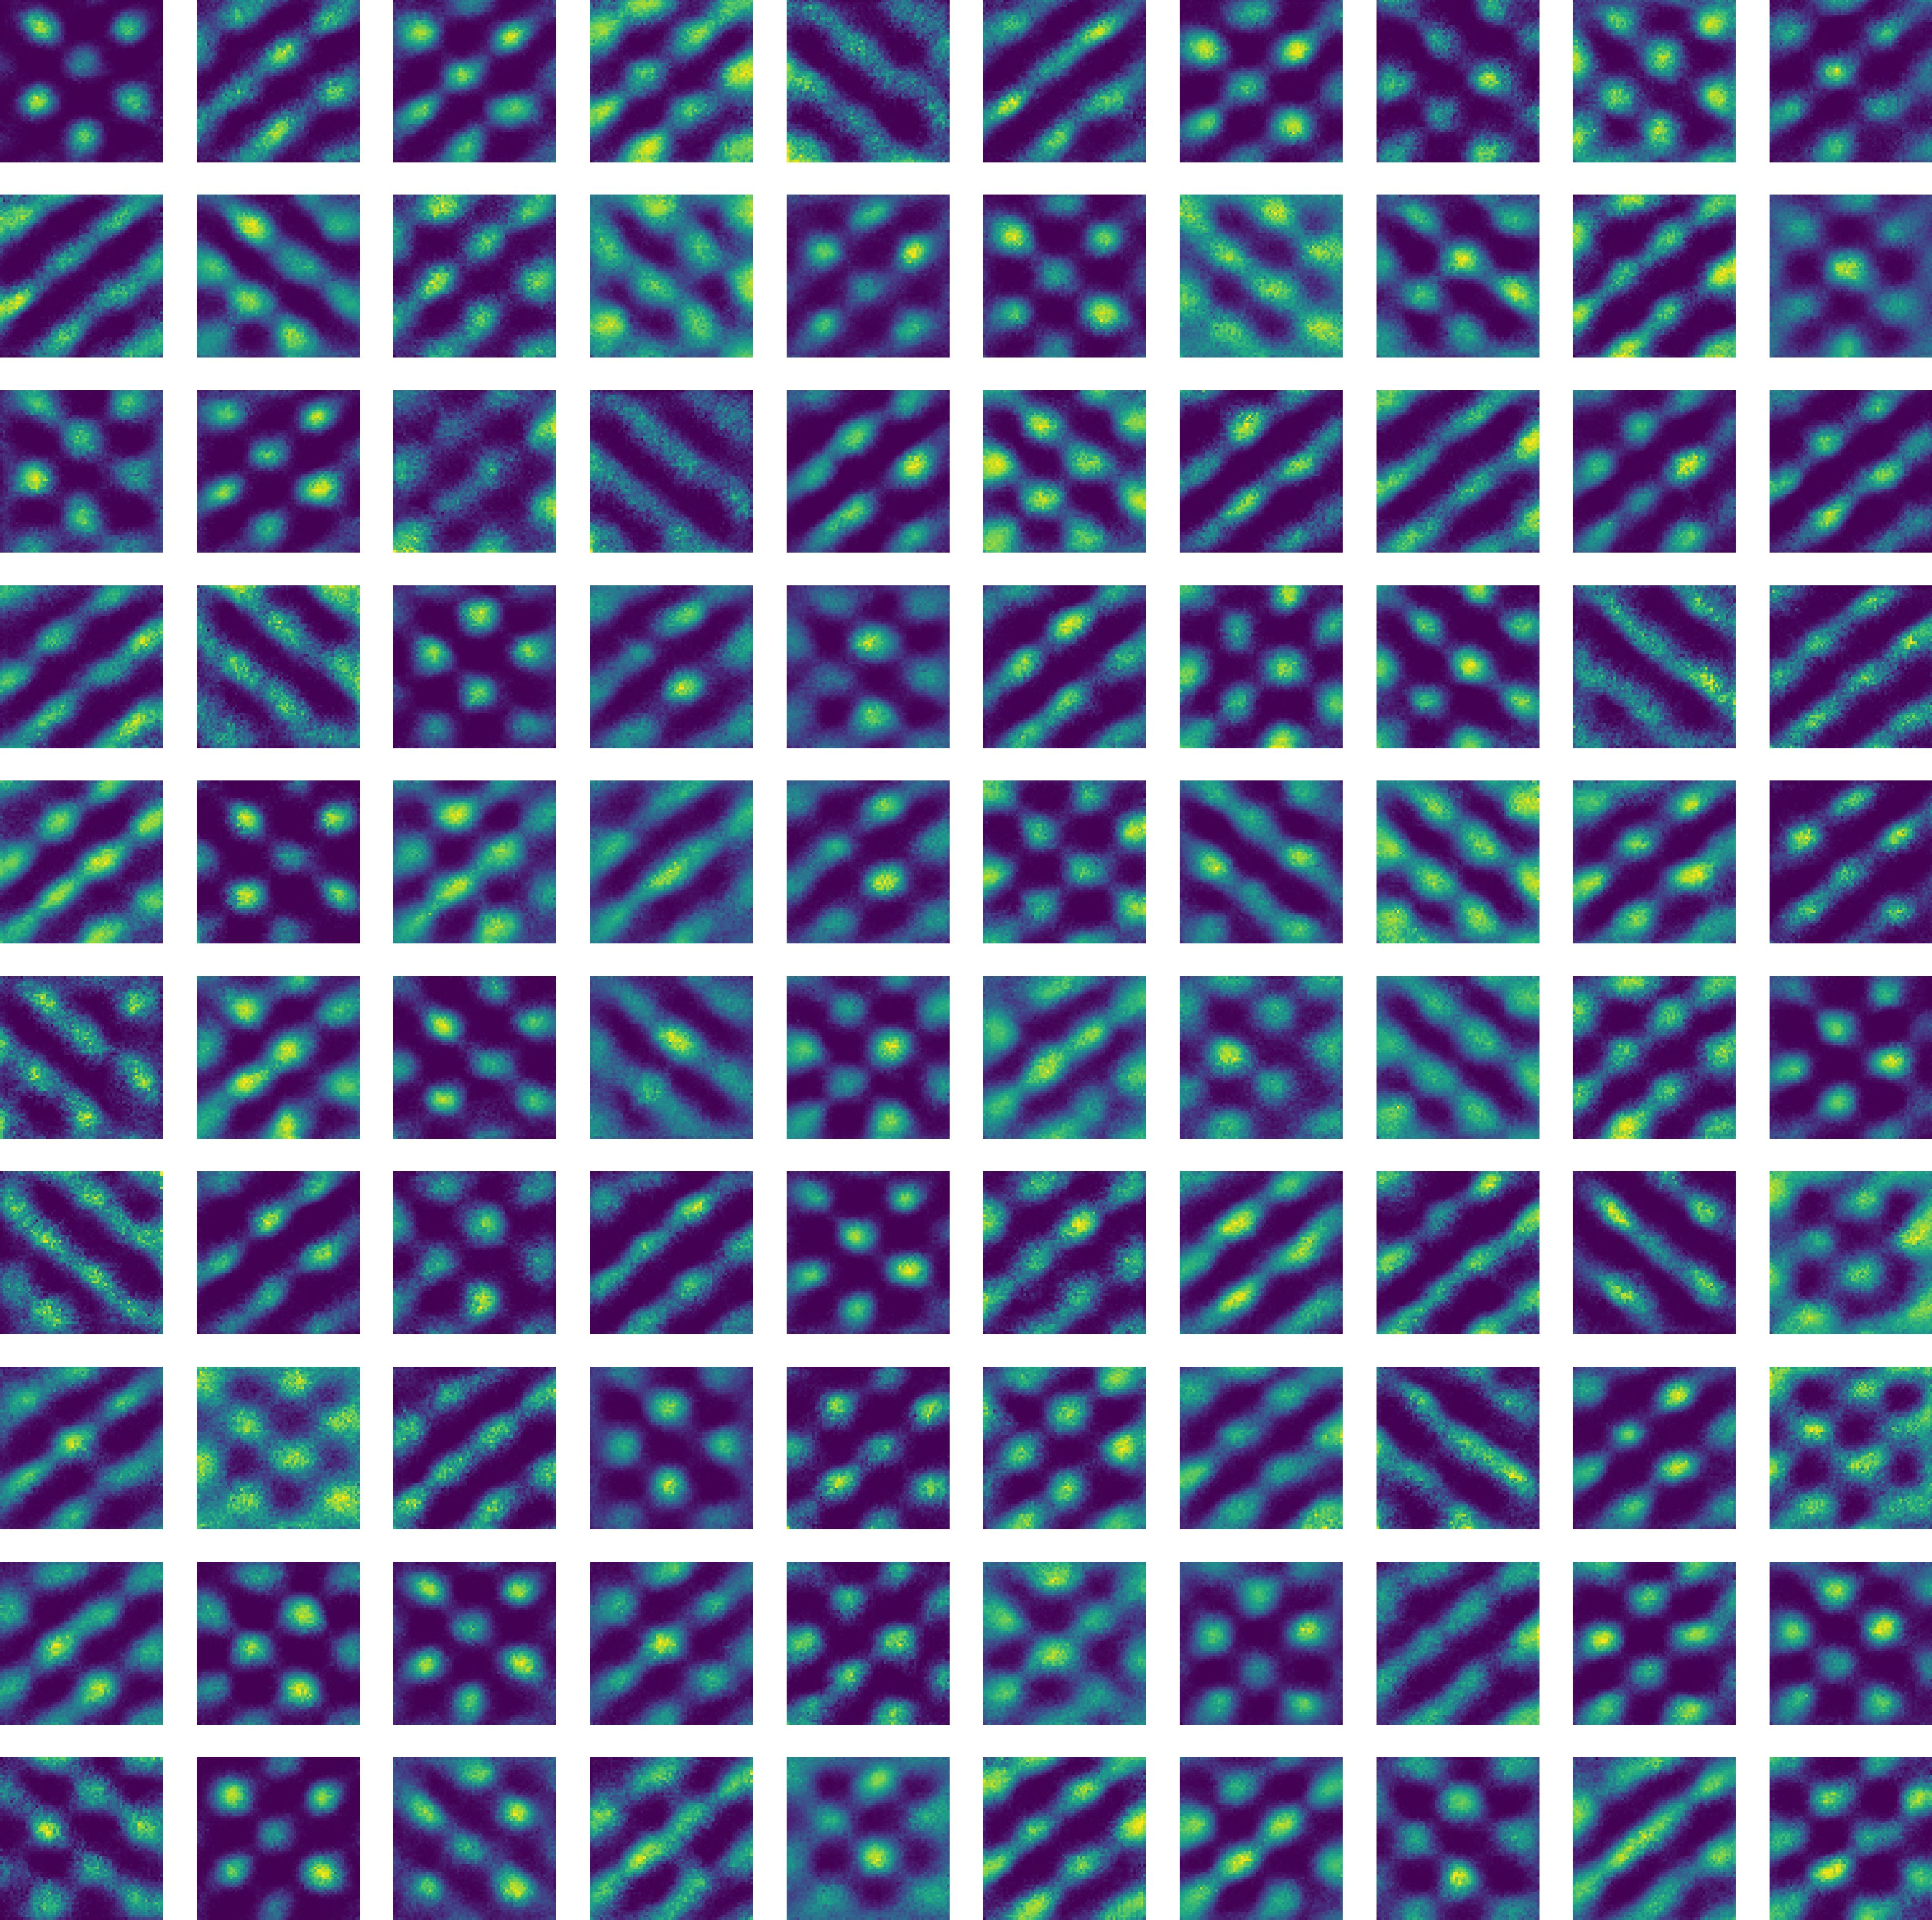

In [11]:
ns = 10 # ns x ns grid of unit ratemaps
count = 0
fig, ax = plt.subplots(ns,ns, figsize = (15,15))
for i in range(ns):
    for j in range(ns):
        im = ax[i,j].imshow(ratemaps[count])
        ax[i,j].axis("off")
        count += 1

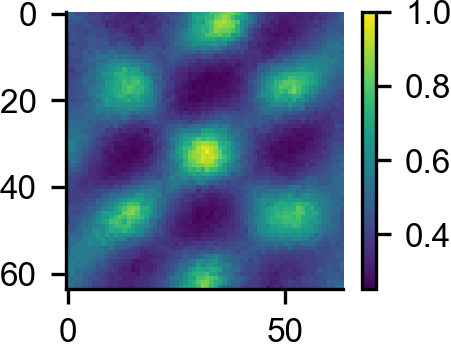

In [12]:
sim = np.exp(np.sum(-(ratemaps - ratemaps[:,32,32][:,None,None])**2, axis = 0))
plt.imshow(sim) # spatial similarity with origin
plt.colorbar()

In [13]:
decoders = []
decoder_losses = []
band_scores = []

for ind in check_steps:
    name = f"./train_history_models/RNNGC_{ind}.pkl"
    model = RNNGC()
    model = model.load(name)
    decoder = LinearDecoder(model.ng, 2)
    optimizer = torch.optim.Adam(decoder.parameters(), lr = 1e-3)

    loss_history = []
    for i in tqdm(range(train_steps)):
        r, v = dataset.generate_data(bs, timesteps)
        g = model((r[:,0], v))

        loss = decoder.train_step(torch.cat((g[:,1:], r[:,:-1]),dim=-1), r[:,1:], optimizer = optimizer)
        loss_history.append(loss)
        
    decoder_losses.append(loss_history)
    decoders.append(decoder)

100%|██████████| 50000/50000 [02:46<00:00, 300.87it/s]


In [14]:
len(decoders), check_steps

(5, [0, 100, 1000, 10000, 49999])

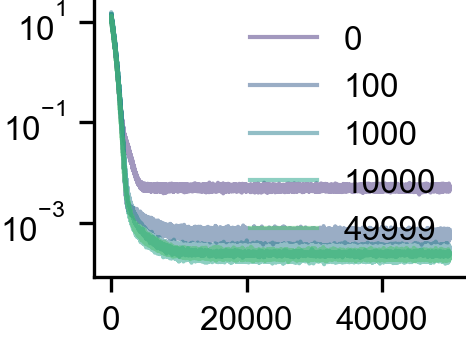

In [15]:
for i, loss in enumerate(decoder_losses):
    plt.semilogy(loss, alpha = 0.5, label = check_steps[i])

plt.legend(frameon = False)

In [45]:
r_eval, v_eval = dataset.generate_data(1000, 10*timesteps)
# r_eval = r_eval - r_eval[:,0, None]
baseline_loss = torch.linalg.norm(r_eval, axis=-1).detach().numpy()

In [46]:
eval_losses = []

for i in range(len(check_steps)):
    name = f"./train_history_models/RNNGC_{check_steps[i]}.pkl"
    model = RNNGC()
    model = model.load(name)
    decoder = decoders[i]
    g_eval = model((r_eval[:,0], v_eval))
    r_pred = decode(g_eval, decoder, r0 = r_eval[:,0])
    eval_losses.append(torch.linalg.norm(r_pred - r_eval, axis = -1).detach().numpy())

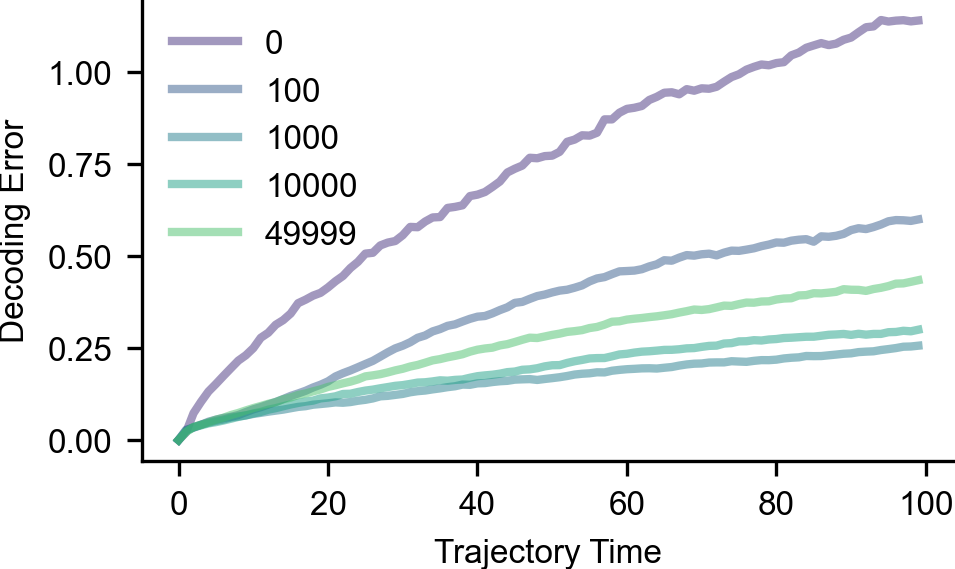

In [68]:
plt.figure(figsize = (3.5,2))

# plt.plot(np.median(baseline_loss,axis=0), "--", label = "Zero baseline")
# plt.fill_between(np.arange(baseline_loss.shape[1]), np.percentile(baseline_loss, 25, axis=0), np.percentile(baseline_loss, 75, axis=0), alpha = 0.25)

for i, loss in enumerate(eval_losses):
    plt.plot(np.median(loss, axis=0), alpha = 0.5, label = check_steps[i], linewidth = 2)
    # plt.fill_between(np.arange(baseline_loss.shape[1]), np.percentile(loss, 25, axis=0), np.percentile(loss, 75, axis=0), alpha = 0.25)
plt.legend(frameon = False)
plt.xlabel("Trajectory Time")
plt.ylabel("Decoding Error")
plt.savefig("./review_figs/train_history_error")

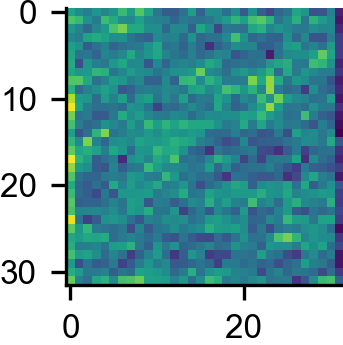

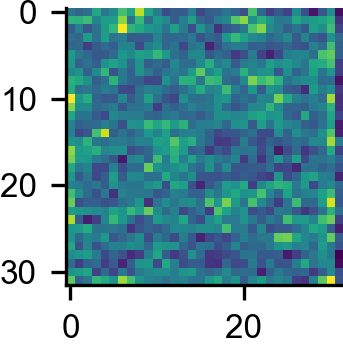

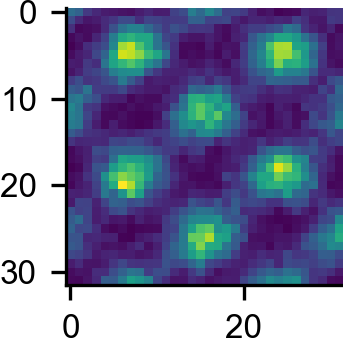

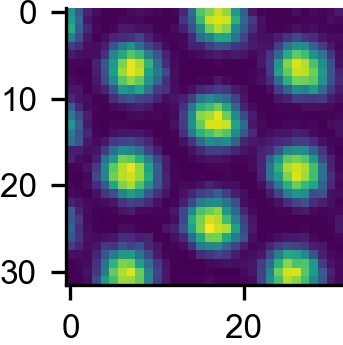

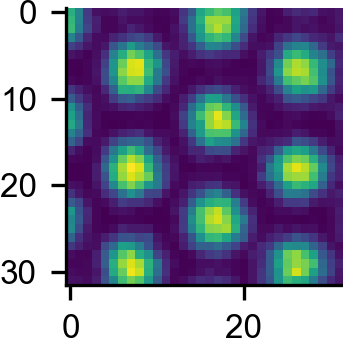

In [41]:
import review_utils

eval_losses = []
band_scores = []
for i in range(len(check_steps)):
    name = f"./train_history_models/RNNGC_{check_steps[i]}.pkl"
    model = RNNGC()
    model = model.load(name)
    decoder = decoders[i]
    g_eval = model((r_eval[:,0], v_eval)).detach().numpy()
    ratemaps = scipy.stats.binned_statistic_2d(r_eval[...,0].ravel().detach().numpy(), r_eval[...,1].ravel().detach().numpy(), 
                                               g_eval.reshape(-1, g_eval.shape[-1]).T, bins = 32)[0]
    
    band_scores.append([review_utils.band_score(ratemap, 4*np.pi) for ratemap in ratemaps])
    plt.imshow(ratemaps[0])
    plt.show()

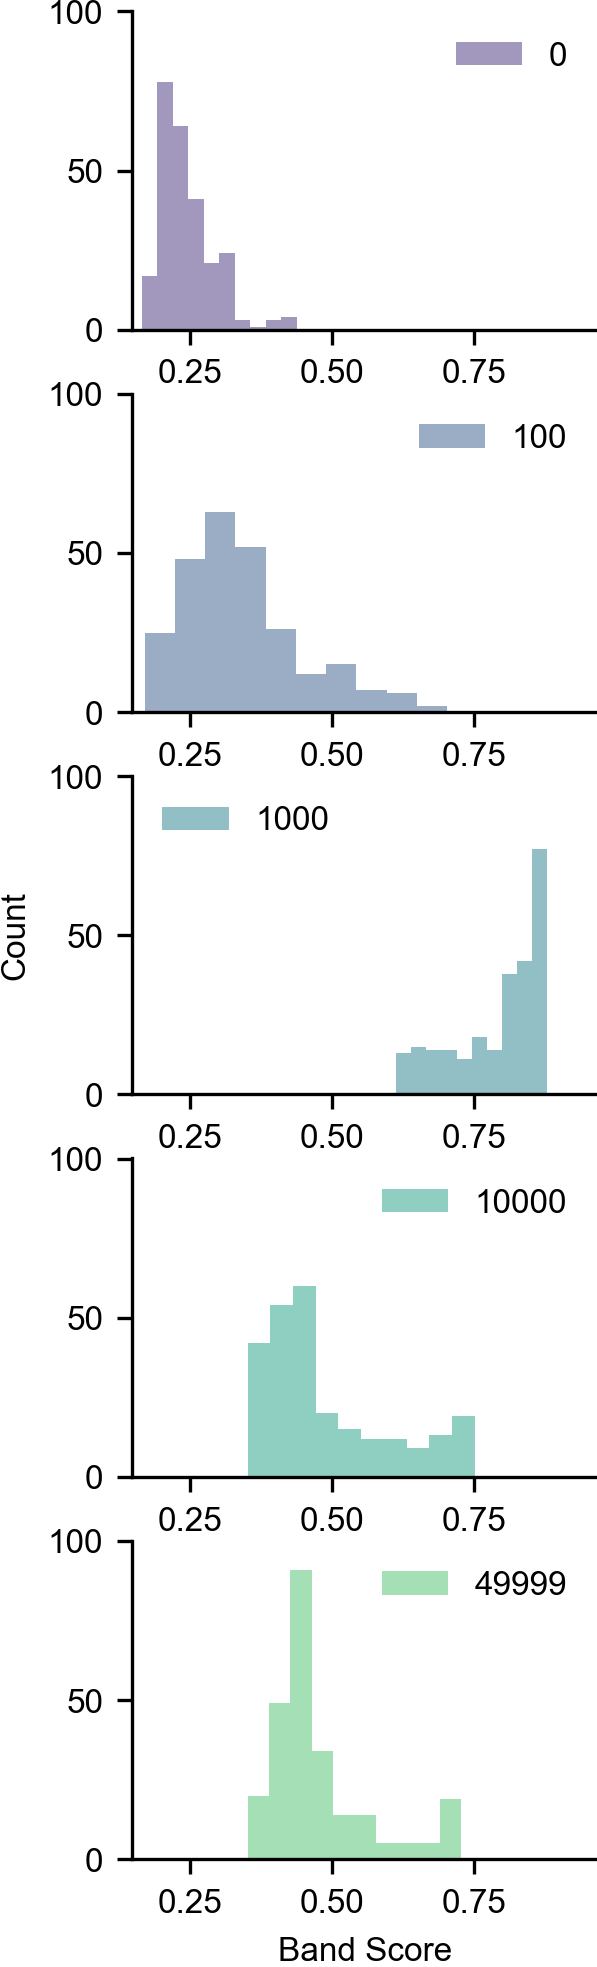

In [69]:
fig, ax = plt.subplots(5, 1, figsize = (2, 8))
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']  # Extract the colors from the cycle

max_count = 0

for i, scores in enumerate(band_scores):
    count = ax[i].hist(scores,color=colors[i % len(colors)], alpha = 0.5, label = check_steps[i])[0]
    ax[i].set_xlim([np.amin(band_scores)*0.9, 1.1*np.amax(band_scores)])
    if np.amax(count) > max_count:
        max_count = np.amax(count)
    ax[i].legend(frameon = False)
[axi.set_ylim([0, max_count*1.1]) for axi in ax]
ax[-1].set_xlabel("Band Score")
ax[2].set_ylabel("Count")
plt.savefig("./review_figs/band_scores")

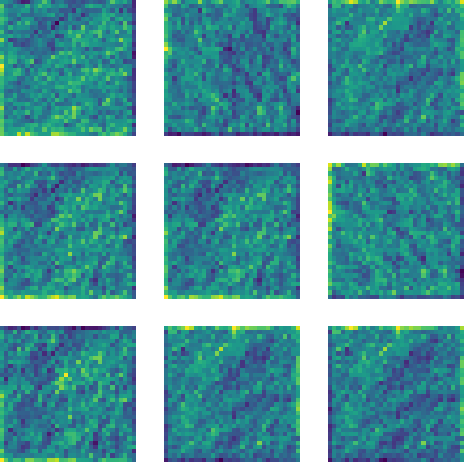

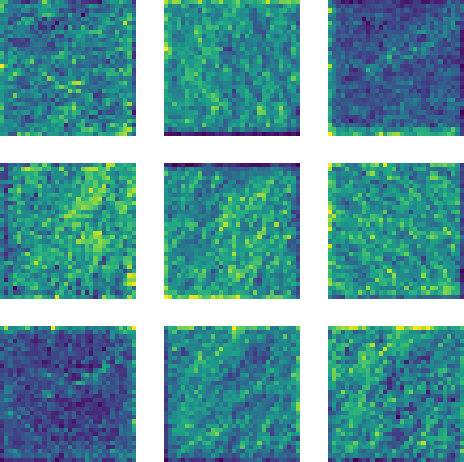

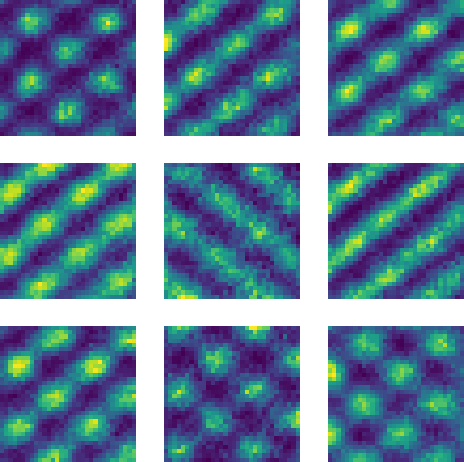

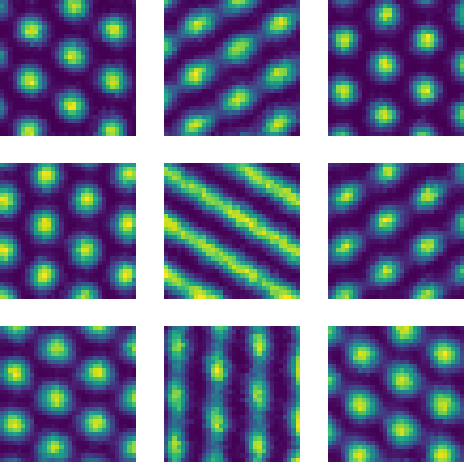

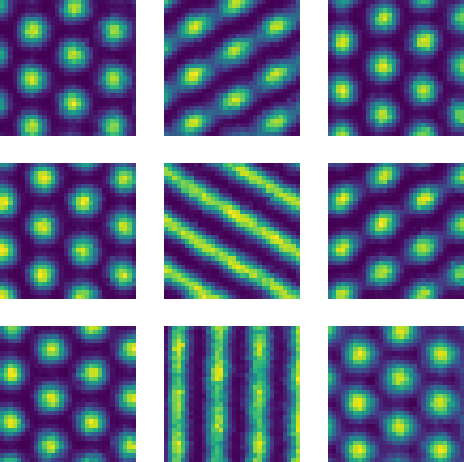

In [72]:
ns = 3 # ns x ns grid of unit ratemaps

eval_losses = []
band_scores = []
for i in range(len(check_steps)):
    name = f"./train_history_models/RNNGC_{check_steps[i]}.pkl"
    model = RNNGC()
    model = model.load(name)
    decoder = decoders[i]
    g_eval = model((r_eval[:,0], v_eval)).detach().numpy()
    ratemaps = scipy.stats.binned_statistic_2d(r_eval[...,0].ravel().detach().numpy(), r_eval[...,1].ravel().detach().numpy(), 
                                               g_eval.reshape(-1, g_eval.shape[-1]).T, bins = 32)[0]

    count = 0
    fig, ax = plt.subplots(ns,ns, figsize = (2,2))
    for k in range(ns):
        for l in range(ns):
            im = ax[k,l].imshow(ratemaps[count])
            ax[k,l].axis("off")
            count += 1
    plt.savefig(f"./review_figs/train_history_ratemaps_step_{check_steps[i]}")
        